# [MinHash](https://en.wikipedia.org/wiki/MinHash)

## import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import math
from hashlib import md5

mbyte = 1048576

## tools

In [2]:
def generate_md5(H):
    hmd5 = md5()
    hmd5.update(str(H).encode(encoding='utf-8'))
    return hmd5.hexdigest()

## [dataset](https://github.com/ahazxm/Learn-LSH/blob/master/Datasets.ipynb)

In [3]:
%store -r Datasets

In [4]:
mnist = Datasets['MNIST-Hamming']

train = mnist['train']
test = mnist['test']
k_near_neighbors = mnist['k_near_neighbors']
nearest_neighbor = mnist['nearest_neighbor']

## process

In [5]:
def MinHash_process(P, k, L):
    """
    Desc:
        Min Hash LSH
    Args:
        P: 点集
        k: 每一块包含的函数
        L: 共有多少块
    Returns:

    """
    n = P.shape[0]
    d = P.shape[1]
    num_hash = k * L

    # 1. 生成 hash 函数
    h_mat = np.arange(1, d + 1)
    H_mat = np.array([np.random.permutation(h_mat) for _ in range(num_hash)])

    buckets = []
    for i in range(L):
        buckets.append(dict())

    for idx, p in enumerate(P):
        h = (p * H_mat).astype(np.float)
        h[h == 0] = np.inf
        h = h.min(axis=1).reshape(L, k)
        # print(h)
        for i in range(L):
            bi = generate_md5(h[i])
            if bi not in buckets[i]:
                buckets[i][bi] = [idx]
            else:
                buckets[i][bi].append(idx)
    
    return H_mat, buckets

## query

In [6]:
def MinHash_query(args, q):
    k, L = args[0]
    H_mat, buckets = args[1]

    d = H_mat.shape[1]
    num_hash = H_mat.shape[0]

    h = (q * H_mat).astype(np.float)
    h[h == 0] = np.inf
    h = h.min(axis=1).reshape(L, k)

    result = []
    for i in range(L):
        bi = generate_md5(h[i])
        if bi in buckets[i]:
            result.append(buckets[i][bi])

    if len(result) != 0:
        result = np.unique(np.concatenate(result))

    return result

## metric

In [21]:
def metrics(P, query_func, args, nearest_neighbor, test):
    correct = 0
    n = P.shape[0]
    total = 0
    selectivity = 0
    for i, q in enumerate(test):
        candidates = query_func(args, q)
        if nearest_neighbor[i] in candidates:
            correct += 1
        selectivity += len(candidates) / n
    
    result = dict()
    result['precision'] = correct / len(test)
    result['selectivity'] = selectivity / len(test)
    
    return result

## test

**Fix L = 8, K = [2, 4, 6, 8, 10]**

In [25]:
%%time
K = [2, 4, 6, 8, 10]
L = 8

arr_precision = []
arr_selectivity = []

for k in K:
    minhash = MinHash_process(train, k, L)
    result = metrics(train, MinHash_query, [(k, L), minhash], nearest_neighbor, test)
    arr_precision.append(result['precision'])
    arr_selectivity.append(result['selectivity'])

CPU times: user 6min 30s, sys: 283 ms, total: 6min 31s
Wall time: 6min 32s


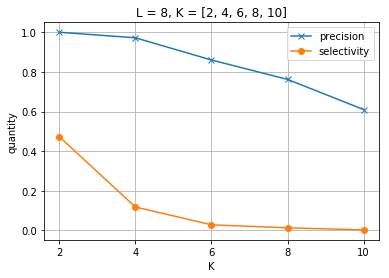

In [33]:
plt.plot(K, arr_precision, marker='x', label='precision')
plt.plot(K, arr_selectivity, marker='o', label='selectivity')

plt.xticks(K)
plt.legend()
plt.grid()
plt.xlabel('K')
plt.ylabel('quantity')
plt.title('L = 8, K = [2, 4, 6, 8, 10]')
plt.show()

**Fix K = 8, L = [4, 6, 8, 10, 12, 14]**

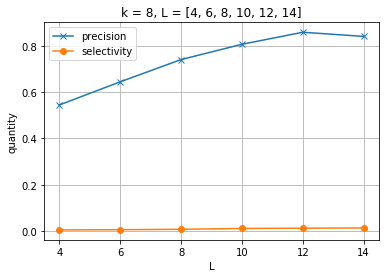

CPU times: user 10min 9s, sys: 509 ms, total: 10min 9s
Wall time: 10min 11s


In [36]:
%%time
k = 8
L = [4, 6, 8, 10, 12, 14]

arr_precision_L = []
arr_selectivity_L = []

for l in L:
    minhash = MinHash_process(train, k, l)
    result = metrics(train, MinHash_query, [(k, l), minhash], nearest_neighbor, test)
    arr_precision_L.append(result['precision'])
    arr_selectivity_L.append(result['selectivity'])
    
plt.plot(L, arr_precision_L, marker='x', label='precision')
plt.plot(L, arr_selectivity_L, marker='o', label='selectivity')

plt.xticks(L)
plt.legend()
plt.grid()
plt.xlabel('L')
plt.ylabel('quantity')
plt.title('k = 8, L = [4, 6, 8, 10, 12, 14]')
plt.show()